In [2]:
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from security_env import SecurityEnv
import pandas as pd

def random_search(n_trials=50, n_steps=10000):
    """
    Perform random search over hyperparameters
    """
    # Define hyperparameter ranges
    param_ranges = {
        'learning_rate': np.logspace(-5, -3, 100),
        'n_steps': [2048, 4096, 8192],
        'batch_size': [32, 64, 128],
        'n_epochs': [5, 10, 20],
        'gamma': [0.95, 0.99, 0.995],
        'gae_lambda': [0.9, 0.95, 0.98],
        'clip_range': [0.1, 0.2, 0.3],
        'ent_coef': [0.0, 0.01, 0.005],
        'alpha': [0.3, 0.5, 0.7],
        'beta': [0.3, 0.5, 0.7],
        's_min': [5.0, 8.0, 10.0]
    }
    
    results = []
    
    for trial in range(n_trials):
        # Randomly sample hyperparameters
        params = {k: np.random.choice(v) for k, v in param_ranges.items()}
        
        # Create environment
        env = SecurityEnv(
            rf_model_path="fatigue_model.joblib",
            alpha=params['alpha'],
            beta=params['beta'],
            s_min=params['s_min']
        )
        env = DummyVecEnv([lambda: env])
        
        # Create and train model
        model = PPO(
            "MlpPolicy",
            env,
            learning_rate=params['learning_rate'],
            n_steps=params['n_steps'],
            batch_size=params['batch_size'],
            n_epochs=params['n_epochs'],
            gamma=params['gamma'],
            gae_lambda=params['gae_lambda'],
            clip_range=params['clip_range'],
            ent_coef=params['ent_coef'],
            verbose=0
        )
        
        # Train model
        model.learn(total_timesteps=n_steps)
        
        # Evaluate model
        eval_env = SecurityEnv(
            rf_model_path="fatigue_model.joblib",
            alpha=params['alpha'],
            beta=params['beta'],
            s_min=params['s_min']
        )
        eval_env = DummyVecEnv([lambda: eval_env])
        
        mean_reward, std_reward = evaluate_model(model, eval_env)
        
        # Store results
        results.append({
            'trial': trial,
            'params': params,
            'mean_reward': mean_reward,
            'std_reward': std_reward
        })
        
        print(f"Trial {trial + 1}/{n_trials}")
        print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
        print("-" * 50)
    
    # Convert results to DataFrame and save
    results_df = pd.DataFrame(results)
    results_df.to_csv('random_search_results.csv', index=False)
    return results_df

def evaluate_model(model, env, n_episodes=5):
    """Evaluate a trained model"""
    rewards = []
    for _ in range(n_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            episode_reward += reward
        rewards.append(episode_reward)
    return np.mean(rewards), np.std(rewards)

In [2]:
results = random_search(n_trials=50, n_steps=10000)

Trial 1/50
Mean Reward: -87.07 ± 0.32
--------------------------------------------------
Trial 2/50
Mean Reward: 401.48 ± 1.17
--------------------------------------------------
Trial 3/50
Mean Reward: 271.86 ± 0.41
--------------------------------------------------
Trial 4/50
Mean Reward: -285.20 ± 1.42
--------------------------------------------------
Trial 5/50
Mean Reward: -409.71 ± 0.69
--------------------------------------------------
Trial 6/50
Mean Reward: 354.17 ± 0.50
--------------------------------------------------
Trial 7/50
Mean Reward: -249.24 ± 11.06
--------------------------------------------------
Trial 8/50
Mean Reward: -331.02 ± 16.26
--------------------------------------------------
Trial 9/50
Mean Reward: -10.48 ± 1.49
--------------------------------------------------
Trial 10/50
Mean Reward: 192.08 ± 0.32
--------------------------------------------------
Trial 11/50
Mean Reward: 267.51 ± 1.22
--------------------------------------------------
Trial 12/50
M

Data with extracted hyperparameters:
   trial                                             params  mean_reward  \
0      0  {'learning_rate': 0.00019630406500402724, 'n_s...    -87.07301   
1      1  {'learning_rate': 6.734150657750829e-05, 'n_st...    401.48090   
2      2  {'learning_rate': 0.0005462277217684342, 'n_st...    271.85700   
3      3  {'learning_rate': 1.747528400007683e-05, 'n_st...   -285.19775   
4      4  {'learning_rate': 7.742636826811278e-05, 'n_st...   -409.71338   

   std_reward  learning_rate  n_steps  batch_size  n_epochs  gamma  \
0    0.317985       0.000196   2048.0       128.0      10.0  0.990   
1    1.169231       0.000067   8192.0        32.0      20.0  0.990   
2    0.413785       0.000546   2048.0        64.0      10.0  0.995   
3    1.422479       0.000017   2048.0        64.0      10.0  0.995   
4    0.685735       0.000077   4096.0        64.0      10.0  0.990   

   gae_lambda  clip_range  ent_coef  alpha  beta  s_min  
0        0.98         0.3  

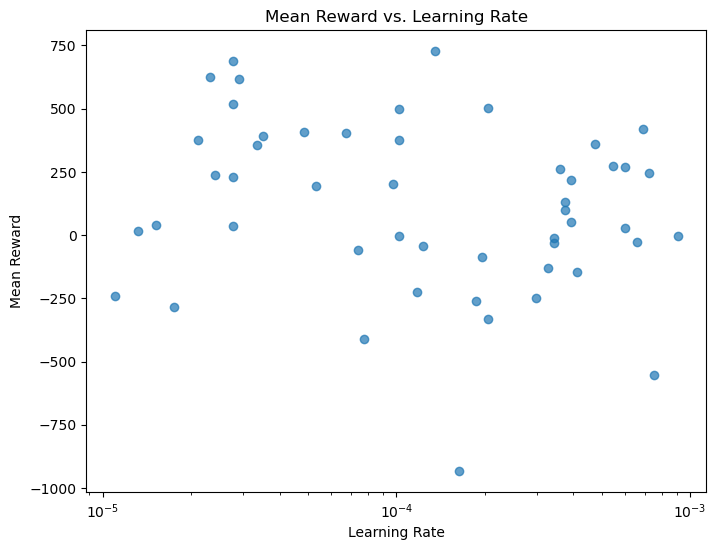

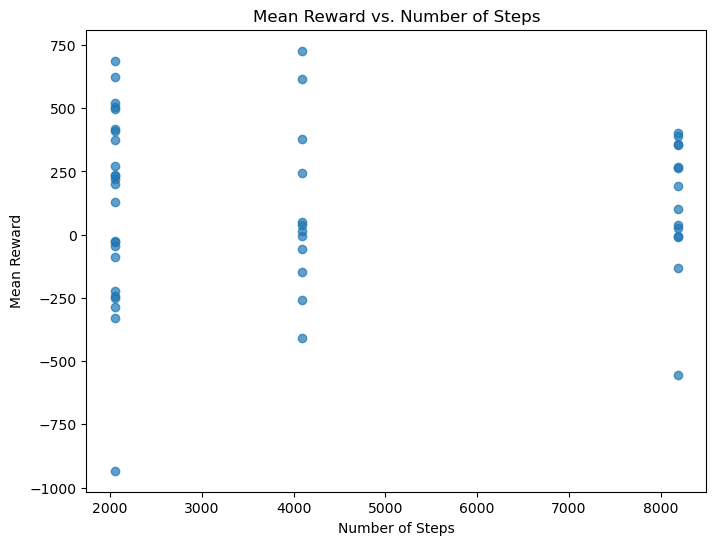

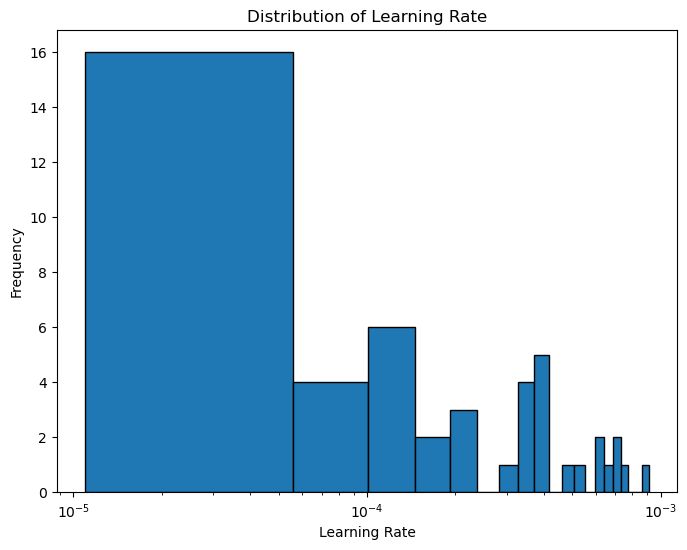

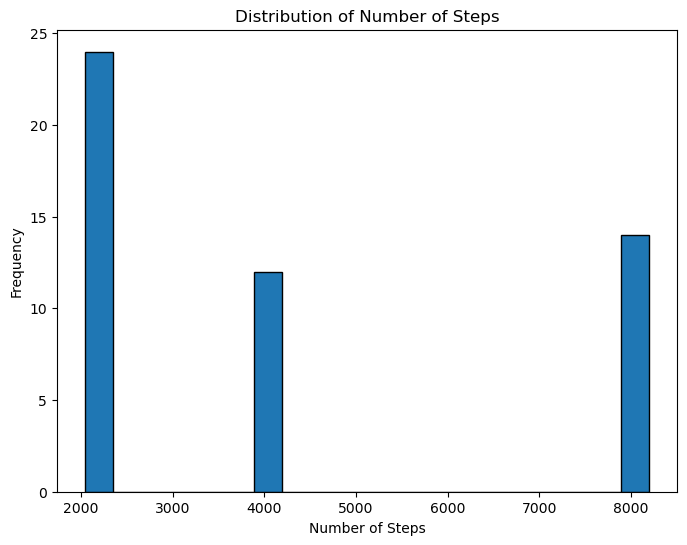

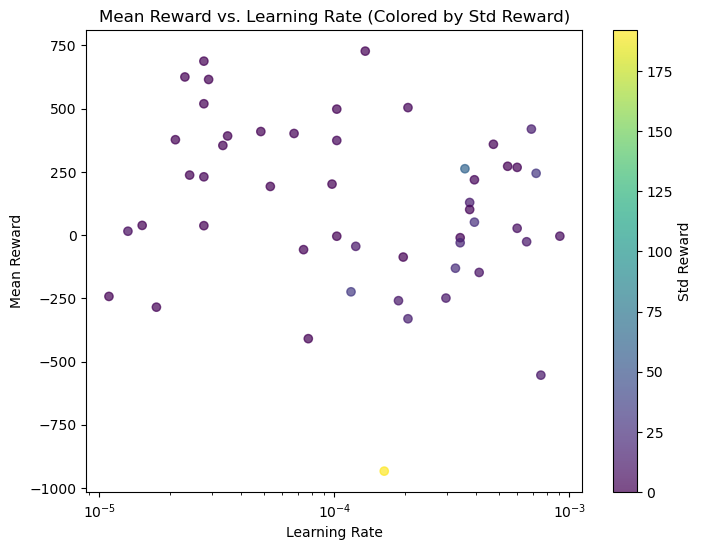

In [3]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv(r"C:\Users\Tuan Anh HSLU\OneDrive - Hochschule Luzern\Desktop\HSLU22\Bachelor Thesis\ML Models\random_search_results.csv")

# Function to safely parse the parameters string into a dictionary
def parse_params(param_str):
    try:
        return ast.literal_eval(param_str)
    except Exception as e:
        print("Error parsing params:", e)
        return {}

# Convert the 'params' column from string to dictionary and create new columns
params_series = df['params'].apply(parse_params).apply(pd.Series)
df = pd.concat([df, params_series], axis=1)

# Display the first few rows to check the extracted hyperparameters
print("Data with extracted hyperparameters:")
print(df.head())

# Plot 1: Scatter Plot of Mean Reward vs. Learning Rate
plt.figure(figsize=(8,6))
plt.scatter(df['learning_rate'], df['mean_reward'], alpha=0.7)
plt.xlabel('Learning Rate')
plt.ylabel('Mean Reward')
plt.title('Mean Reward vs. Learning Rate')
plt.xscale('log')  # Using log scale for learning rate for better visualization
plt.show()

# Plot 2: Scatter Plot of Mean Reward vs. Number of Steps (if exists)
if 'n_steps' in df.columns:
    plt.figure(figsize=(8,6))
    plt.scatter(df['n_steps'], df['mean_reward'], alpha=0.7)
    plt.xlabel('Number of Steps')
    plt.ylabel('Mean Reward')
    plt.title('Mean Reward vs. Number of Steps')
    plt.show()

# Plot 3: Histogram of Learning Rate Distribution
plt.figure(figsize=(8,6))
plt.hist(df['learning_rate'], bins=20, edgecolor='k')
plt.xlabel('Learning Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Learning Rate')
plt.xscale('log')
plt.show()

# Plot 4: Histogram of n_steps Distribution (if exists)
if 'n_steps' in df.columns:
    plt.figure(figsize=(8,6))
    plt.hist(df['n_steps'], bins=20, edgecolor='k')
    plt.xlabel('Number of Steps')
    plt.ylabel('Frequency')
    plt.title('Distribution of Number of Steps')
    plt.show()

# Plot 5: Scatter Plot with Color Indicating Std Reward
if 'std_reward' in df.columns:
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(df['learning_rate'], df['mean_reward'], 
                          c=df['std_reward'], cmap='viridis', alpha=0.7)
    plt.xlabel('Learning Rate')
    plt.ylabel('Mean Reward')
    plt.title('Mean Reward vs. Learning Rate (Colored by Std Reward)')
    plt.xscale('log')
    plt.colorbar(scatter, label='Std Reward')
    plt.show()
